In [33]:
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.sparse as scsp
import numpy as np
import os
import json
from tqdm.notebook import tqdm

Make the paths match what you want to analyze and where to store the results

Currently analyzing every matrix in a folder will mean every file with matrix in its name, and the .mm or .bin extension depending on what you want

In [41]:
# matrix_folder = "/home/tobias/opm/build_release/sim_results/24jan/31/verbose_spe1/reports/"
result_file_name = "verbose_spe1"
# the path to amgcl bin2mm can be whatever if convert_from_binary is False
# set convert_from_binary to True if you want to convert from binary
convert_from_binary = False
amgcl_bin_to_mm_converter = "/home/tobias/Downloads/amgcl/build/examples/bin2mm"

BLOCKSIZE = 2 # the blocksize of the matrices in the folder
N_BLOCK_SPARSITY_PATTERNS = 2**(BLOCKSIZE*BLOCKSIZE)
BLOCK_SPARSITY_WITH_TOLERANCE = False

analyze_matrix computes various characteristics of a bsr matrix and returns the results in a dictionary
Currently the function computes:
* Mean nonzero entries per row
* Median nonzero entries per row
* Min number of nonzero entries in a row
* max number of nonzero entries in a row
* whether or not the matrix is symmetric
* a bitmasked array showing the amount of blocks with each possible sparsity pattern

In [35]:
# these constants are used to index the resulting tuple from sio.mminfo
ROWS = 0
COLS = 1
ENTRIES = 2

def analyze_matrix(matrix, metadata):
    # compute a histogram of how many nonzero entries are in each row of the matrix
    M = len(matrix.indptr) - 1
    rowHistogram = np.zeros(M, dtype=int)
    for i in range(1, M+1):
        rowHistogram[i-1] = matrix.indptr[i]-matrix.indptr[i-1]

    # use the histogram to compute simple statistical characteristics of the matrix
    median = np.median(rowHistogram)
    min_nnz = np.min(rowHistogram)
    max_nnz = np.max(rowHistogram)
    arithmetic_mean = np.mean(rowHistogram)

    # check if the matrix is symmetric
    # this part of the code is a bit slow, could be sped up by avoiding the allocation
    # for every matrix by allocating the space just once
    symmetric = True
    matrix_T = matrix.transpose(copy=True)
    indptr_matches = bool((matrix.indptr==matrix_T.indptr).all())
    indices_matches = bool((matrix.indices==matrix_T.indices).all())
    if not (indptr_matches and indices_matches):
        symmetric = False
    del matrix_T

    bit_masked_count = [0]*N_BLOCK_SPARSITY_PATTERNS
    bit_masked_with_tolerance_count = [0]*N_BLOCK_SPARSITY_PATTERNS
    for block_idx in range(len(matrix.data)):
        # print(type(np.absolute(matrix.data[block_idx])))
        L = np.absolute(matrix.data[block_idx]).max()
        TOL = np.float64(1e-8)

        mask = 0
        tol_mask = 0

        for i in range(BLOCKSIZE*BLOCKSIZE):
            entry_value = np.abs(matrix.data[block_idx][i//BLOCKSIZE][i%BLOCKSIZE])
            mask += int(2**i) if entry_value != np.float64(0.0) else 0
            tol_mask += int(2**i) if entry_value > L*TOL else 0

        bit_masked_count[mask] += 1
        bit_masked_with_tolerance_count[tol_mask] += 1

    return {
        "nnz" : str(metadata[ENTRIES]),
        "dims" : str([metadata[ROWS], metadata[COLS]]),
        "median" : str(median),
        "minNnzInRow" : str(min_nnz),
        "maxNnzInRow" : str(max_nnz),
        "mean" : str(arithmetic_mean),
        "symmetric" : str(symmetric),
        "blockSparsity" : str(bit_masked_count),
        "blockSparsityWithTolerance" : str(bit_masked_with_tolerance_count)
    }

In [36]:
# this function returns true if the filename provided has "matrix" in it and the extension is the same as the one provided
def matrix_filter(filename, extension):
    if "matrix_istl_0.mm" not in filename:
        return False
    if len(extension) > len(filename):
        return False
    if filename[len(filename) - len(extension):] != extension:
        return False
    return True

analysis_results = {}

if convert_from_binary:
    pass
else:
    files = os.scandir(matrix_folder)
    filenames = []
    for f in files:
        filenames.append(f.name)
    filenames = list(filter(lambda e: matrix_filter(e, ".mm"), filenames))

    for matrix_file in tqdm(filenames):
        # Read in the file as a BSR matrix
        path_to_matrix = matrix_folder + matrix_file
        try:
            matrix_metadata = sio.mminfo(path_to_matrix)
            matrix = sio.mmread(path_to_matrix)
            matrix = matrix.tobsr([BLOCKSIZE,BLOCKSIZE])

            analysis_results[matrix_file] = analyze_matrix(matrix, matrix_metadata)
        except:
            analysis_results[matrix_file] = {"FAILED ANALYSIS" : "FAILED ANALYSIS"}
            print("analysis failed for", matrix_file)

  0%|          | 0/300 [00:00<?, ?it/s]

In [37]:
with open(result_file_name + '.json', 'w', encoding='utf-8') as f:
    json.dump(analysis_results, f, ensure_ascii=False, indent=4)

Read the collected data from all the matrices into a python dictionary again after backing it up to a .json

In [38]:
collected_data = json.load(open(result_file_name + '.json'))

In [39]:
failed = 0
succeeded = 0
for key, value in collected_data.items():
    if len(value) == 1:
        failed += 1
    else:
        succeeded += 1

print(succeeded,"/",failed+succeeded, "matrices were analyzed successfully (", 100*succeeded/(failed+succeeded), "% )")

300 / 300 matrices were analyzed successfully ( 100.0 % )


Note that when making the plots, we assume that the filenames in sorted order corresponds with chronological order
The binary numbers above the plot show the sparsity pattern of the block. This is stored in a row wise order where a 1 indicates a nonzero number, while a 0 indicates a 0 value. The bit string 1001 will then represent a block on the form [[a, 0], [0, b]], a != 0 and b != 0

  0%|          | 0/300 [00:00<?, ?it/s]

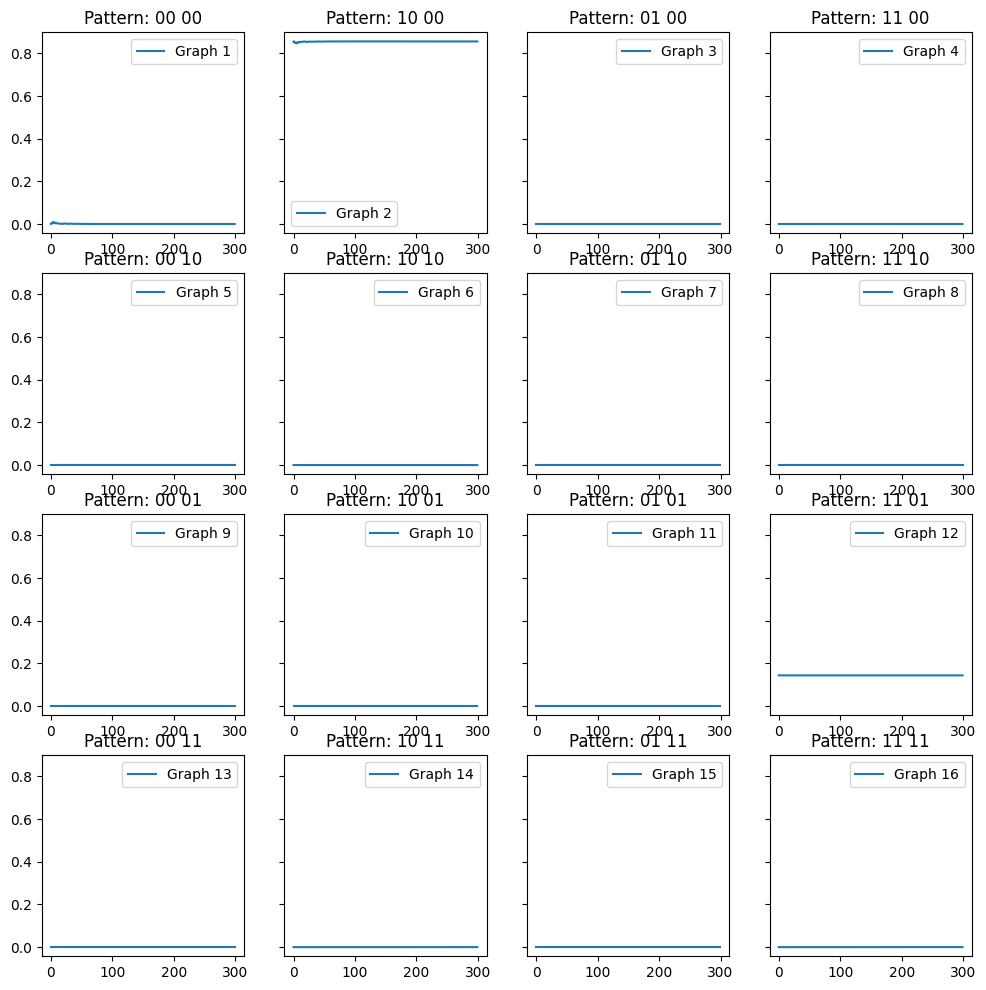

In [42]:
from ast import literal_eval

# this sort function is used to sort names of the following kind
# primarily on time, and secondarily on newton iteration
# example file name: prob_2_time_7677966.55068389__nit_3_matrix_istl_0.mm
def custom_sort(item):
    fname = item[0]
    # the logic behind this line is avoid the affect of trailing zeroes by casting to float
    time = float(fname.split("_")[3])
    newton_it = int(fname.split("_")[6])
    return (time, newton_it)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharey=True)
axes = axes.flatten()

block_sparsity_data = [[] for i in range(N_BLOCK_SPARSITY_PATTERNS)]
x_values = []

cnt = 0
for item in tqdm(sorted(collected_data.items(), key=custom_sort)):
    # if the analysis failed, dont try to add data
    key = item[0]
    value = item[1]
    if len(value) == 1:
        continue
    # else:
    #     # if the filename
    #     dot_cnt = 0
    #     for char in key:
    #         dot_cnt+=1 if char=='.' else 0
    #     if dot_cnt > 1:
    #         continue

    x_values.append(cnt)
    cnt += 1

    # get the total number of blocks
    total_blocks = float(value["nnz"])/(BLOCKSIZE*BLOCKSIZE)

    for i in range(N_BLOCK_SPARSITY_PATTERNS):
        # get the number of counter occurences of the ith sparsity block type

        string_form_of_list = ""
        if BLOCK_SPARSITY_WITH_TOLERANCE:
            string_form_of_list = value["blockSparsityWithTolerance"]
        else:
            string_form_of_list = value["blockSparsity"]



        list_form_of_string_of_list = literal_eval(string_form_of_list)
        num_of_occurences = list_form_of_string_of_list[i]

        # get the relative occurence to the total amount of nonzero blocks
        concentration = num_of_occurences / total_blocks

        block_sparsity_data[i].append(concentration)

block_patterns = []
for n in range(N_BLOCK_SPARSITY_PATTERNS):
    block_patterns.append([])

    for i in range(BLOCKSIZE):
        string = ""
        for j in range(BLOCKSIZE):
            string += "1" if (n & (1<<(i*BLOCKSIZE + j))) > 0 else "0"
        block_patterns[n].append(string)
    block_patterns[n] = ' '.join(block_patterns[n])

if BLOCKSIZE == 2:
    for i in range(16):
        axes[i].plot(x_values, block_sparsity_data[i], label=f'Graph {i + 1}')
        axes[i].set_title(f'Pattern: {block_patterns[i]}')
        axes[i].legend()
elif BLOCKSIZE == 3:
    cnt = 0
    zerocnt = 0
    for i in range(N_BLOCK_SPARSITY_PATTERNS):
        if max(block_sparsity_data[i]) < 0.00125:
            if max(block_sparsity_data[i]) == 0:
                zerocnt += 1
            continue
        axes[cnt].plot(x_values, block_sparsity_data[i], label=f'Graph {i + 1}')
        axes[cnt].set_title(f'Pattern: {block_patterns[i]}')
        axes[cnt].legend()
        cnt += 1
    print(f"{zerocnt} block patterns never occured in in the matrices")